# Learned Cost Model Evaluation

In [1]:
from copy import deepcopy
import os
import random
import sys
from typing import Any, Optional, Tuple, Type

In [2]:
from matplotlib import cm
from matplotlib.ticker import PercentFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import toml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import polars as pl

pd.set_option('display.max_columns', 50)
pd.set_option('display.min_rows', 20)

In [3]:
plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r'\usepackage{amsmath}\usepackage{amssymb}'
plt.rcParams["font.family"] = r'serif'
plt.rcParams["font.serif"] = r'Computer Modern'

golden_ratio = (1 + 5 ** 0.5) / 2
cm_to_in = 1/2.54  # centimeters in inches
width = 8.45 * cm_to_in
height = width / golden_ratio

In [4]:
sys.path.append('../../')

from axe.lcm.util import LCMEvalUtil
from axe.lcm.data.schema import LCMDataSchema
from axe.lcm.model.builder import LearnedCostModelBuilder
from axe.lsm.types import Policy, LSMBounds, LSMDesign, System
from axe.lsm.cost import Cost
from axe.lcm.util import create_input_from_types
from jobs.train_lcm import TrainLCM

In [5]:
def save_fig(fig, filename, **kwargs):
    fig.savefig(os.path.join('/home/ndhuynh/transfer', filename), dpi=300, format='pdf', bbox_inches='tight', **kwargs)

In [6]:
model_path = '../../data/lcm/models/kaplsm_model/'
config = toml.load(os.path.join(model_path, 'axe.toml'))
policy = getattr(Policy, config['lsm']['policy'])
bounds = LSMBounds(**config['lsm']['bounds']) 
min_t, max_t = bounds.size_ratio_range


In [7]:
config['job']['train_lcm']

{'max_epochs': 10,
 'save_dir': 'data/lcm/models/kaplsm_model',
 'no_checkpoint': False,
 'data_split': 0.9,
 'data_dir': 'data/lcm/train_data/kaplsm',
 'batch_size': 1024,
 'shuffle': True,
 'num_workers': 4,
 'loss_fn': 'MSE',
 'optimizer': 'Adam',
 'lr_scheduler': 'Constant'}

# Loss Graph

epoch          0
train_loss    10
test_loss      5
dtype: int64

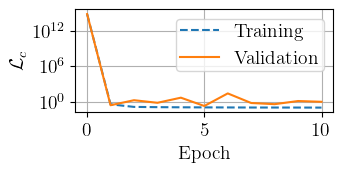

In [8]:
plt.rcParams.update({'font.size': 14})
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
losses = losses.loc[0:]
fig, ax = plt.subplots(figsize=(width, 0.65*height))
ax.plot(losses['epoch'], losses['train_loss'], label='Training', linestyle='--')
ax.plot(losses['epoch'], losses['test_loss'], label='Validation', linestyle='-')
ax.set_xlabel('Epoch')
ax.set_ylabel(r'$\mathcal{{L}}_c$')
ax.set_yscale('log')
ax.set_yticks([1e12,  1e6,  1e0])
ax.grid()
_ = ax.legend(loc='upper right', borderpad=0.2)
losses.idxmin()
# save_fig(fig, 'lcm_loss.pdf')

# Building

## Testing Data

For now lets say all testing data generated by seed=0

In [9]:
SEED = 0
NUM_SAMPLES = 10000

In [10]:
schema = LCMDataSchema(policy=policy, bounds=bounds, seed=SEED)
table = [schema.sample_row_dict() for _ in tqdm(range(NUM_SAMPLES))]
table = pl.DataFrame(table)
table = schema._preprocess_table(table)
table

  0%|          | 0/10000 [00:00<?, ?it/s]

z0_cost,z1_cost,q_cost,w_cost,z0,z1,q,w,entry_p_page,selec,entry_size,mem_budget,num_elem,bits_per_elem,size_ratio,policy,K_0,K_1,K_2,K_3,K_4,K_5,K_6,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,K_16,K_17,K_18,K_19
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,i64,f64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.000562,0.230401,6.448748,0.05838,0.041,0.229,0.367,0.363,32.0,1.9486e-8,1024,18.691334,553264274,13.833,12,3,8.0,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000494,0.857594,0.551903,0.465075,0.003,0.813,0.041,0.143,8.0,2.7764e-8,8192,7.634834,130227017,6.641,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.006102,0.29909,2.634202,0.50318,0.028,0.272,0.123,0.577,8.0,3.3608e-8,4096,14.707843,211854948,9.374,15,3,6.0,7.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.79512,0.054831,5.734216,0.012132,0.65,0.036,0.295,0.019,16.0,6.1497e-8,8192,7.026448,621013097,4.113,14,3,5.0,4.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.211649,0.666123,0.596557,0.006919,0.358,0.531,0.045,0.066,64.0,6.8135e-8,2048,13.9145,614376847,5.33,15,3,6.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.026742,0.277416,0.517422,0.216508,0.079,0.252,0.041,0.628,64.0,3.6417e-8,2048,5.522959,976318919,5.349,1,3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.004222,0.063617,4.948,0.188508,0.062,0.063,0.718,0.157,16.0,5.6023e-8,4096,14.283234,677942276,6.408,10,3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.079983,0.137919,3.015442,0.794822,0.067,0.091,0.139,0.703,8.0,7.2409e-8,4096,12.9027,957546540,2.805,11,3,2.0,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
dataset = table.to_torch(
    return_type="dataset",
    features=schema.feat_cols(),
    label=schema.label_cols(),
    dtype=pl.Float32
)

## Build Model

In [18]:
model_name = os.path.join(model_path, 'best_model.model')
# model_name = os.path.join(model_path, 'checkpoints/epoch_10.checkpoint')
# last_checkpoint = os.listdir(os.path.join(model_path, 'checkpoints'))[-1]
# model_name = os.path.join(model_path, 'checkpoints', last_checkpoint)
model = LearnedCostModelBuilder(schema, **config["lcm"]["model"]).build()
model_data = torch.load(model_name, weights_only=True)
load_status = model.load_state_dict(model_data["model_state_dict"])
model.eval()
load_status

<All keys matched successfully>

In [19]:
ex_input = dataset[0][0]
torchinfo.summary(model, ex_input.unsqueeze(0).shape, device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
KapLCM                                   [1, 4]                    --
├─Linear: 1-1                            [1, 8]                    168
├─Linear: 1-2                            [1, 20, 8]                168
├─BatchNorm1d: 1-3                       [1, 178]                  356
├─Linear: 1-4                            [1, 64]                   11,456
├─ReLU: 1-5                              [1, 64]                   --
├─Dropout: 1-6                           [1, 64]                   --
├─Sequential: 1-7                        [1, 64]                   --
│    └─Linear: 2-1                       [1, 64]                   4,160
│    └─ReLU: 2-2                         [1, 64]                   --
│    └─Linear: 2-3                       [1, 64]                   4,160
│    └─ReLU: 2-4                         [1, 64]                   --
├─Linear: 1-8                            [1, 64]                   4,160

In [20]:
learned_data = [model(feat.unsqueeze(0)) for (feat, label) in dataset]

# LCM Evaluation

## Calculating Cost

In [47]:
df = []
for (feat, label) in tqdm(dataset):
    pred = model(feat.unsqueeze(0))
    df.append({'cost_acm': label.sum().item(), 'cost_lcm': pred.sum().item()})
df = pl.DataFrame(df)
df = pl.concat([table, df], how='horizontal')

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
df = df.with_columns(
    delta=(pl.col('cost_acm') - pl.col('cost_lcm')),
    norm_delta=((pl.col('cost_acm') - pl.col('cost_lcm')) / pl.col('cost_acm'))
)
df[['cost_acm', 'cost_lcm', 'delta', 'norm_delta']]

cost_acm,cost_lcm,delta,norm_delta
f64,f64,f64,f64
6.738091,7.335425,-0.597334,-0.08865
1.875066,2.231236,-0.35617,-0.189951
3.442574,4.211727,-0.769153,-0.223424
6.5963,7.261185,-0.664886,-0.100797
1.481248,1.993768,-0.51252,-0.346006
…,…,…,…
1.038087,1.536982,-0.498895,-0.48059
5.204347,5.957794,-0.753447,-0.144773
4.028166,4.439297,-0.411131,-0.102064


## Normalized Cost Histogram

In [49]:
cutoff = 0.1
data = df.filter((pl.col('norm_delta') < cutoff) & (pl.col('norm_delta') > -cutoff))
print(f'Percentange within {cutoff:.0%} delta: {len(data) / len(df):.3%}')

Percentange within 10% delta: 48.460%


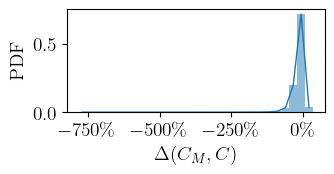

In [50]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(width, 0.65*height))
data = df['norm_delta']
hist, bins, _ = ax.hist(data, bins=30, alpha=0.5, weights=np.ones_like(data)/len(data))
# ax.hist(data, bins=50, density=True)
bin_center = (bins[1:] + bins[:-1]) / 2
ax.plot(bin_center, hist, color='tab:blue', linewidth=1)
ax.set_xlabel(r'$\Delta(C_{M}, C)$')
ax.set_ylabel('PDF')
ax.xaxis.set_major_formatter(PercentFormatter(1))
# save_fig(fig, 'lcm_normalized_cost.pdf')

In [56]:
def plot_workload_trend(table: pl.DataFrame, trend='stune_T'):
    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
    fig.add_axes(ax)
    ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
    ax.set_xticks([0, 0.5, 1]), ax.set_yticks([0, 0.5, 1]), ax.set_zticks([0, 0.5, 1])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)
    ax.set_yticks([0.5])

    ax.set_xlabel('Point-Reads', labelpad=10)
    ax.set_ylabel('Range-Reads', labelpad=10)
    ax.set_zlabel('Writes', labelpad=10)

    sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df[trend], cmap='viridis')
    cbar = plt.colorbar(sc)
    cbar.set_label(trend)
    
    return fig, ax, sc, cbar

Text(0.5, 0.92, 'Performance Over Workloads')

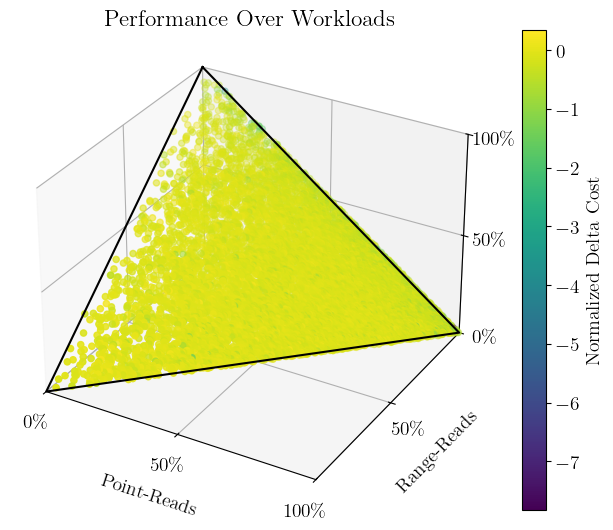

In [61]:
fig, ax, sc, cbar = plot_workload_trend(df, 'norm_delta')
cbar.set_label('Normalized Delta Cost')
ax.set_title('Performance Over Workloads', pad=-10)
# save_fig(fig, 'lcm_delta_over_workload.pdf')

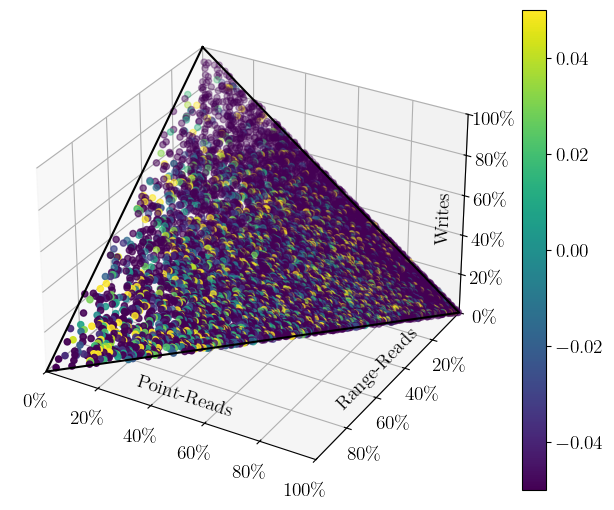

In [60]:
fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)
# ax.set_yticks([0.5])

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)

sc = ax.scatter(df['z0'] + df['z1'], df['q'], df['w'], c=df['norm_delta'], cmap='viridis', vmin=-0.05, vmax=0.05)
cbar = plt.colorbar(sc)
# cbar.set_label()

<>:19: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\%'
<>:19: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\g'
<>:20: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_2832417/13117415.py:19: SyntaxWarning: invalid escape sequence '\%'
  ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label=f'Great ($<$ {cutoff*100:.0f}\%)', alpha=0.3, marker='+', color='tab:green', rasterized=True)
/tmp/ipykernel_2832417/13117415.py:20: SyntaxWarning: invalid escape sequence '\g'
  ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor ($\ge$ {cutoff*100:.0f}\%)', alpha=1, marker='.', color='black', rasterized=True, s=10)
/tmp/ipykernel_2832417/13117415.py:20: SyntaxWarning: invalid escape sequence '\%'
  ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor ($\ge$ {cutoff*100:.0f}\%)'

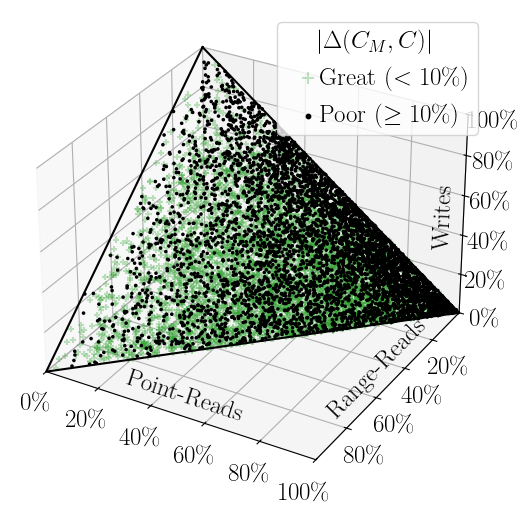

In [64]:
plt.rcParams.update({'font.size': 18})
cutoff = (0.1)
groupa = df.filter(pl.col('norm_delta') > -cutoff)
groupb = df.filter(pl.col('norm_delta') < -cutoff)

fig = plt.figure()
ax = Axes3D(fig, auto_add_to_figure=False, computed_zorder=False)
fig.add_axes(ax)
ax.set_xlim3d(0, 1), ax.set_ylim3d(1, 0), ax.set_zlim3d(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8])
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.zaxis.set_major_formatter(mtick.PercentFormatter(1.0))
edge = ax.plot([0, 1, 0, 0], [0, 0, 1, 0], [1, 0, 0, 1], color='black', zorder=3)

ax.set_xlabel('Point-Reads', labelpad=-30)
ax.set_ylabel('Range-Reads', labelpad=-30)
ax.set_zlabel('Writes', labelpad=-30)
ax.scatter(groupa['z0'] + groupa['z1'], groupa['q'], groupa['w'], label=f'Great ($<$ {cutoff*100:.0f}\%)', alpha=0.3, marker='+', color='tab:green', rasterized=True)
ax.scatter(groupb['z0'] + groupb['z1'], groupb['q'], groupb['w'], label=f'Poor ($\\ge$ {cutoff*100:.0f}\%)', alpha=1, marker='.', color='black', rasterized=True, s=10)
# ax.set_title(f'Performance Cutoff for Tunings: $\pm${cutoff:.0%} Delta Cost')
ax.legend(title=r'$|\Delta(C_M, C)|$', loc='upper right', handletextpad=-0.5, markerscale=2, borderpad=0.25)
plt.show()
# save_fig(fig, 'lcm_perf_cutoff.pdf')